In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, r2_score, mean_absolute_error, classification_report, plot_confusion_matrix, accuracy_score
from scipy.stats import reciprocal, randint
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

# Exploración

In [13]:
df = pd.read_csv('winequality-white.csv', sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [14]:
df.quality.value_counts(sort=False)

4     163
8     175
5    1457
9       5
6    2198
3      20
7     880
Name: quality, dtype: int64

In [15]:
X = df.drop(columns='quality')
sc = StandardScaler()
X = sc.fit_transform(X)
y = df.quality

In [16]:
y_list = [['Calidad con todos los valores', y],
          ['Calidad con 2 clases', pd.cut(y, bins=[0, 5.5, 10], labels=[0, 1])],
          ['Calidad con 3 clases uniforme', pd.cut(y, bins=[0, 4.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 3 clases no uniforme', pd.cut(y, bins=[0, 5.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 4 clases', pd.cut(y, bins=[0, 4.5, 5.5, 6.5, 10], labels=[0, 1, 2, 3])]
         ]
y_list[0][1] = y_list[0][1].map({3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:8})

In [17]:
#Función para determinar y graficar las variables independientes mas importantes
def plot_feature_importances(clf, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    clf.fit(X_train, y_train)
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

# Modelos simples

## Regresión Logística

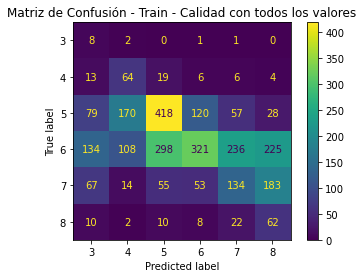

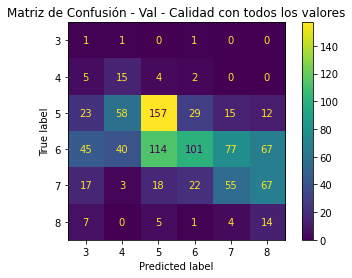

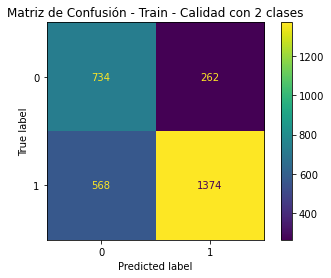

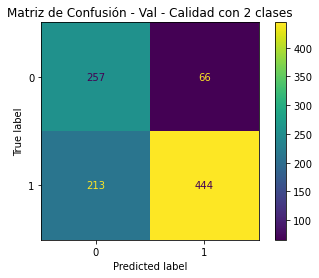

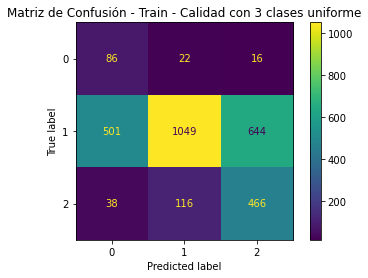

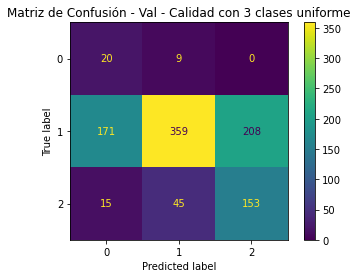

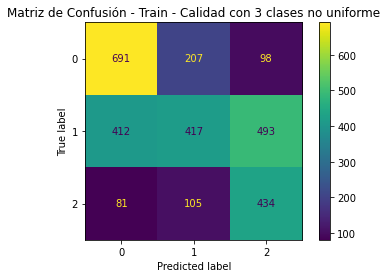

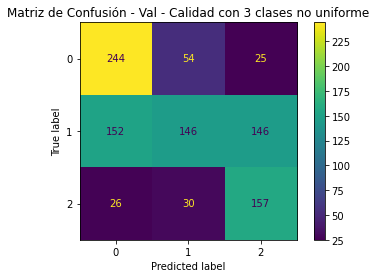

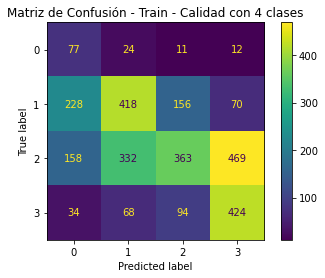

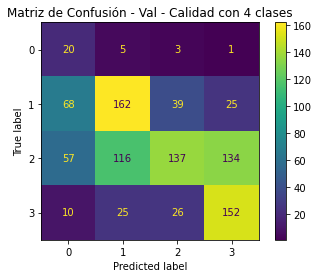

Wall time: 3min 53s


In [18]:
%%time
list_lr = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    log_est = LogisticRegression(class_weight='balanced', 
                                                multi_class='multinomial',
                                                solver='newton-cg',
                                                fit_intercept=True, 
                                                penalty='l2',
                                                max_iter=500)

    dists = {'C': reciprocal(1e-4, 1e4)}

    lr = RandomizedSearchCV(log_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    lr.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(lr, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(lr, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_lr.append([Y[0], 
                   f1_score(y_train, lr.predict(X_train), average='macro'),
                   f1_score(y_val, lr.predict(X_val), average='macro'),
                   accuracy_score(y_train, lr.predict(X_train)),
                   accuracy_score(y_test, lr.predict(X_test)),
                   f1_score(y_train, lr.predict(X_train), average=None),
                   f1_score(y_test, lr.predict(X_test), average=None)]
                  )

In [19]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:,.4f}'.format
labels_metrics = ['Variables', 'F1 Score Train', 'F1 Score Val','Accuracy Train','Accuracy Test','F1 Train Scores for each class', 'F1 Test Scores for each class']
df_metrics_lr = pd.DataFrame(list_lr, columns=labels_metrics)
df_metrics_lr

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.2752,0.2623,0.3428,0.3265,"[0.04953560371517028, 0.2711864406779661, 0.5, 0.3506280720917531, 0.2785862785862786, 0.2012987...","[0.0, 0.2, 0.5145797598627787, 0.31840796019900497, 0.2529411764705883, 0.16216216216216217]"
1,Calidad con 2 clases,0.7034,0.7045,0.7175,0.7194,"[0.6388163620539599, 0.7680268306316377]","[0.6328437917222964, 0.772914946325351]"
2,Calidad con 3 clases uniforme,0.4613,0.4424,0.5449,0.5571,"[0.22963951935914553, 0.6205264714581484, 0.5337915234822451]","[0.18518518518518517, 0.6312056737588653, 0.551948051948052]"
3,Calidad con 3 clases no uniforme,0.5227,0.5562,0.5248,0.5286,"[0.6339449541284404, 0.4066309117503656, 0.5276595744680851]","[0.6153846153846154, 0.4076809453471196, 0.5633802816901409]"
4,Calidad con 4 clases,0.4101,0.4392,0.4364,0.4490,"[0.24798711755233493, 0.4877479579929988, 0.3730729701952724, 0.5316614420062696]","[0.18604651162790697, 0.5109243697478992, 0.374414976599064, 0.5507246376811594]"


## Máquina de Soporte Vecotrial (SVM)

{'C': 7.29073846496744, 'gamma': 0.5291382795766477}


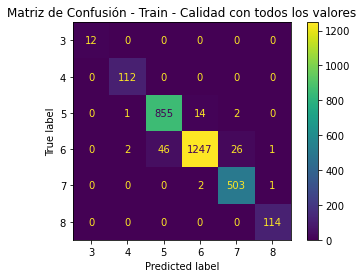

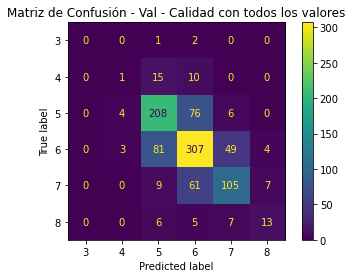

{'C': 1.9632035484945005, 'gamma': 0.40321290670646726}


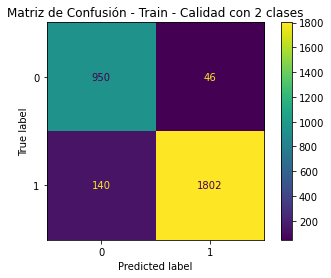

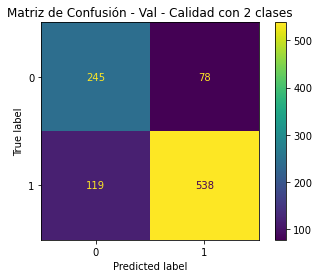

{'C': 61.8257846720877, 'gamma': 0.5188015252885392}


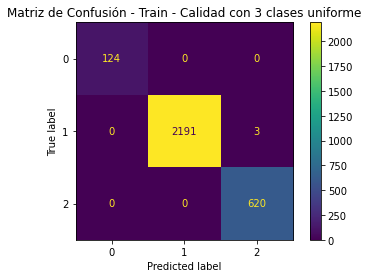

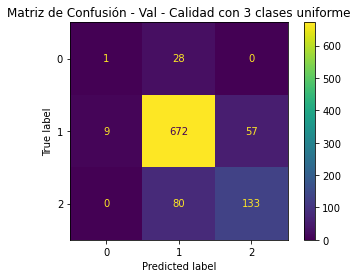

{'C': 1.9078519027696337, 'gamma': 0.44184427151583444}


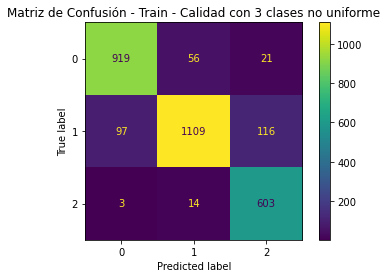

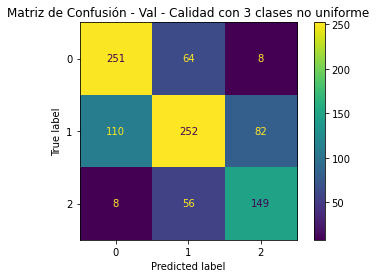

{'C': 11.723712705502018, 'gamma': 0.5571981199581688}


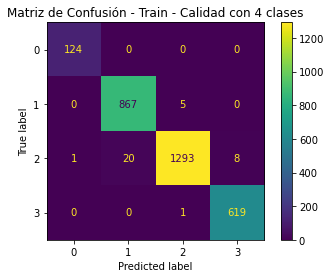

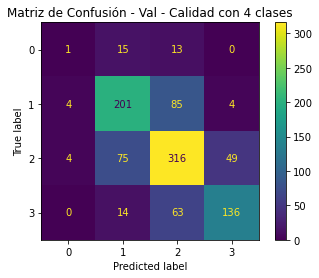

Wall time: 43min 52s


In [20]:
%%time
list_svm = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_est = SVC(kernel='rbf', class_weight='balanced')

    dists = {'gamma':reciprocal(0.01, 100),'C': reciprocal(1e-4, 1e4)}

    svm = RandomizedSearchCV(svm_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    svm.fit(X_train, y_train)
    print(svm.best_params_)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm.append([Y[0], 
                   f1_score(y_train, svm.predict(X_train), average='macro'),
                   f1_score(y_val, svm.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm.predict(X_train)),
                   accuracy_score(y_test, svm.predict(X_test)),
                   f1_score(y_train, svm.predict(X_train), average=None),
                   f1_score(y_test, svm.predict(X_test), average=None)]
                   )

In [21]:
df_metrics_svm = pd.DataFrame(list_svm, columns=labels_metrics)
df_metrics_svm

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.9796,0.4149,0.9677,0.6296,"[1.0, 0.986784140969163, 0.9644670050761421, 0.9647969052224371, 0.970106075216972, 0.9913043478...","[0.0, 0.32432432432432434, 0.6504854368932039, 0.645381984036488, 0.6166666666666667, 0.50793650..."
1,Calidad con 2 clases,0.9309,0.7792,0.9367,0.7888,"[0.9108341323106424, 0.9509234828496043]","[0.6887218045112781, 0.8401544401544401]"
2,Calidad con 3 clases uniforme,0.9990,0.5322,0.9990,0.8265,"[1.0, 0.9993158494868871, 0.997586484312148]","[0.27272727272727276, 0.887844190732035, 0.6697892271662763]"
3,Calidad con 3 clases no uniforme,0.8953,0.6675,0.8955,0.6531,"[0.9121588089330025, 0.8868452618952418, 0.8867647058823529]","[0.6795827123695977, 0.6217870257037944, 0.6694915254237288]"
4,Calidad con 4 clases,0.9903,0.5216,0.9881,0.6551,"[0.9959839357429718, 0.9857873791927232, 0.9866463181991605, 0.9927826784282278]","[0.27906976744186046, 0.6428571428571428, 0.6567505720823799, 0.7072599531615925]"


## Árbol de Decisión

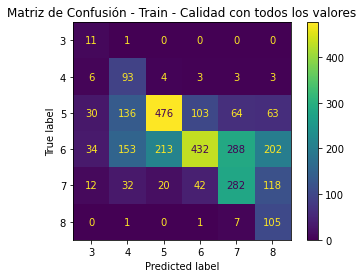

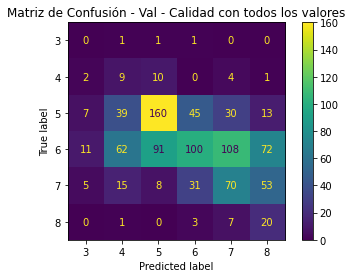

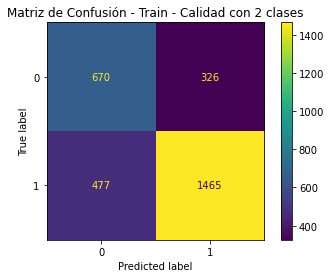

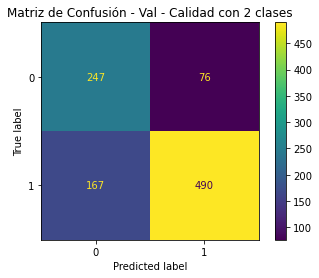

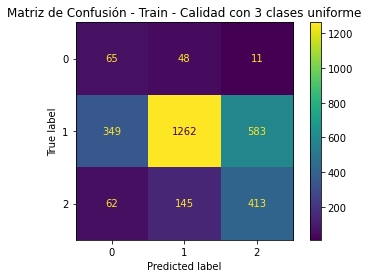

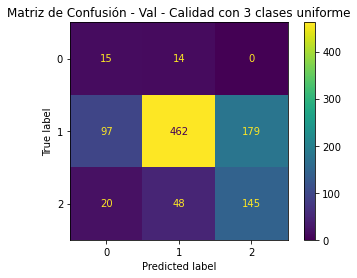

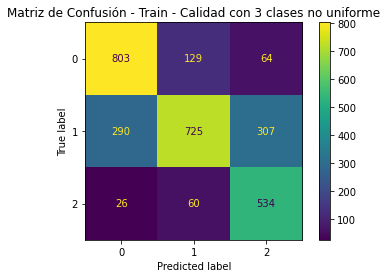

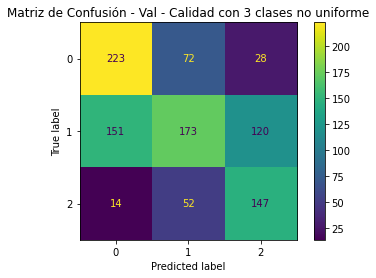

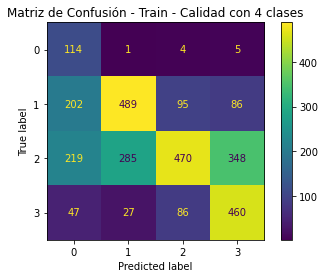

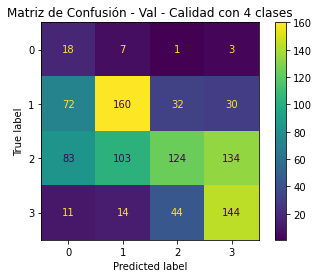

Wall time: 42.9 s


In [22]:
%%time
list_tree = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    tree_est = DecisionTreeClassifier(class_weight='balanced')

    dists = {'max_depth':range(2, 100),'min_samples_leaf': range(10, 1000)}

    tree = RandomizedSearchCV(tree_est, param_distributions = dists, n_iter=200, scoring='f1_macro')

    tree.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(tree, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(tree, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_tree.append([Y[0], 
                   f1_score(y_train, tree.predict(X_train), average='macro'),
                   f1_score(y_val, tree.predict(X_val), average='macro'),
                   accuracy_score(y_train, tree.predict(X_train)),
                   accuracy_score(y_test, tree.predict(X_test)),
                   f1_score(y_train, tree.predict(X_train), average=None),
                   f1_score(y_test, tree.predict(X_test), average=None)]
                   )

In [23]:
df_metrics_tree = pd.DataFrame(list_tree, columns=labels_metrics)
df_metrics_tree

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.4090,0.2609,0.4762,0.3592,"[0.20952380952380953, 0.3522727272727273, 0.6006309148264984, 0.45401996847083553, 0.49043478260...","[0.05555555555555555, 0.16666666666666666, 0.5074626865671641, 0.3472668810289389, 0.37340153452..."
1,Calidad con 2 clases,0.7051,0.7358,0.7267,0.7122,"[0.6252916472235185, 0.7848915081703723]","[0.5948275862068966, 0.7768987341772152]"
2,Calidad con 3 clases uniforme,0.4720,0.4862,0.5922,0.6061,"[0.21666666666666667, 0.6916963551657989, 0.5076828518746158]","[0.13953488372093023, 0.7092547092547093, 0.5255731922398589]"
3,Calidad con 3 clases no uniforme,0.7027,0.5577,0.7018,0.5245,"[0.7593380614657211, 0.6484794275491951, 0.700327868852459]","[0.6014388489208633, 0.4239888423988843, 0.5583941605839416]"
4,Calidad con 4 clases,0.4971,0.4142,0.5218,0.4367,"[0.3229461756373937, 0.5842293906810038, 0.4754678806272129, 0.6056616194865042]","[0.1507537688442211, 0.5008880994671403, 0.3721633888048412, 0.5549348230912476]"


# Métodos de Ensamble

## Random Forest

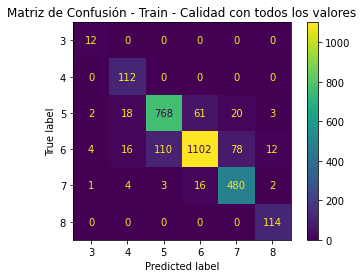

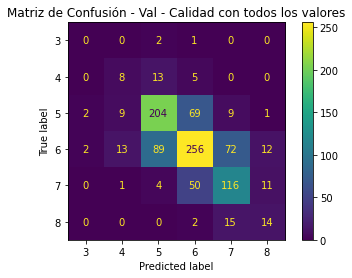

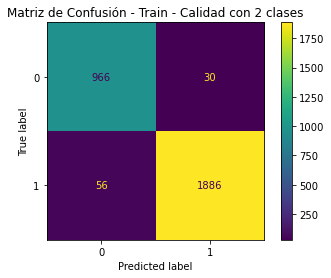

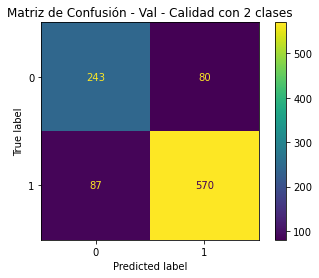

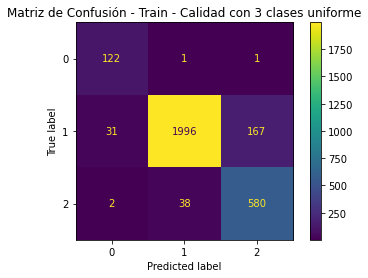

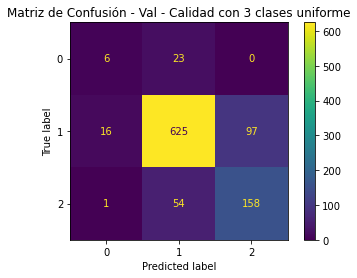

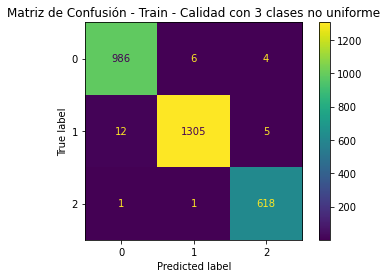

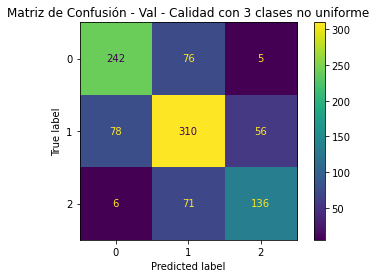

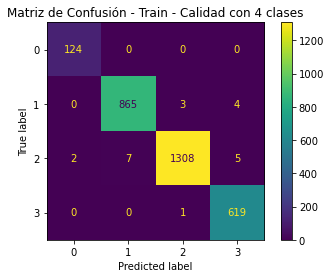

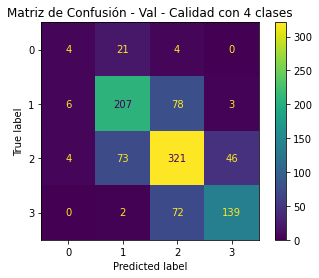

Wall time: 8min 47s


In [24]:
%%time
list_forest = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    forest_est = RandomForestClassifier(class_weight='balanced')

    dists = {'n_estimators':range(20, 100), 'max_depth':(2, 50), 'min_samples_leaf':range(2, 50)}
    
    forest = RandomizedSearchCV(forest_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    forest.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(forest, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(forest, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_forest.append([Y[0], 
                   f1_score(y_train, forest.predict(X_train), average='macro'),
                   f1_score(y_val, forest.predict(X_val), average='macro'),
                   accuracy_score(y_train, forest.predict(X_train)),
                   accuracy_score(y_test, forest.predict(X_test)),
                   f1_score(y_train, forest.predict(X_train), average=None),
                   f1_score(y_test, forest.predict(X_test), average=None)]
                   )

In [25]:
df_metrics_forest = pd.DataFrame(list_forest, columns=labels_metrics)
df_metrics_forest

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.8671,0.4280,0.8809,0.6082,"[0.7741935483870968, 0.8549618320610688, 0.8762122076440388, 0.8812475009996003, 0.8856088560885...","[0.25, 0.4150943396226415, 0.6387959866220736, 0.6178266178266179, 0.6019417475728155, 0.4571428..."
1,Calidad con 2 clases,0.9675,0.8082,0.9707,0.8122,"[0.9573835480673936, 0.9777086573354069]","[0.7169230769230769, 0.8595419847328244]"
2,Calidad con 3 clases uniforme,0.8888,0.5913,0.9183,0.8010,"[0.8745519713261649, 0.9439583825963586, 0.8479532163742689]","[0.32142857142857145, 0.8637640449438201, 0.6708333333333334]"
3,Calidad con 3 clases no uniforme,0.9902,0.6991,0.9901,0.7102,"[0.9884711779448621, 0.9908883826879271, 0.9911788291900562]","[0.7326120556414218, 0.6945701357466062, 0.7086247086247085]"
4,Calidad con 4 clases,0.9923,0.5678,0.9925,0.6786,"[0.9919999999999999, 0.9919724770642202, 0.9931662870159453, 0.9919871794871795]","[0.3043478260869565, 0.673434856175973, 0.6888888888888889, 0.7044917257683216]"


## Bagging de SVM

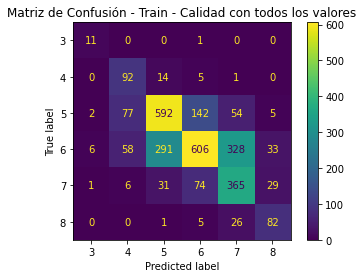

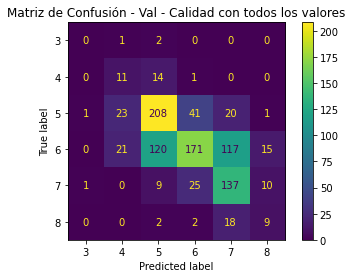

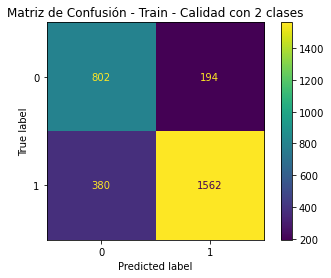

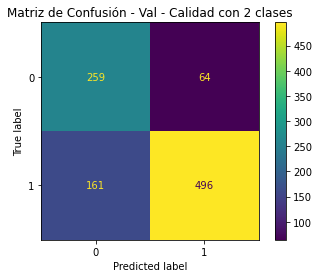

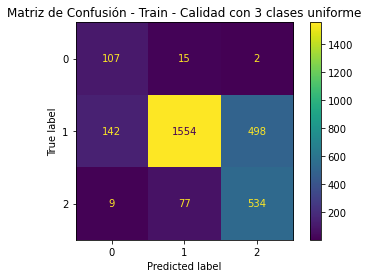

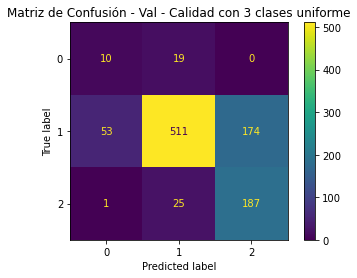

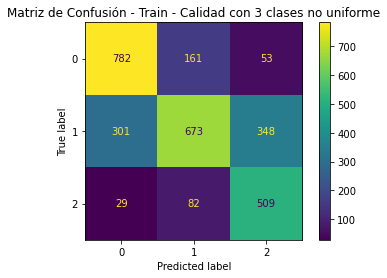

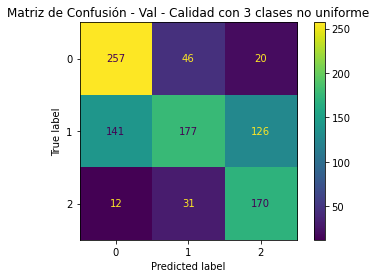

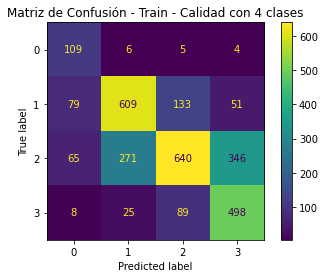

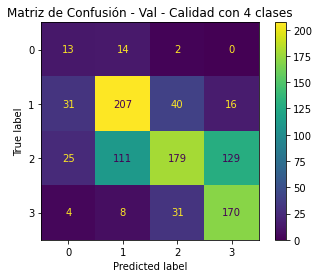

Wall time: 3h 44min 9s


In [26]:
%%time
list_svm_bag = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_bag_est = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=10, gamma=0.05, class_weight='balanced'), max_samples=2/3)

    dists = {'n_estimators':range(20, 100)}
    
    svm_bag = GridSearchCV(svm_bag_est, param_grid = dists, scoring='f1_macro')

    svm_bag.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm_bag, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm_bag, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm_bag.append([Y[0], 
                   f1_score(y_train, svm_bag.predict(X_train), average='macro'),
                   f1_score(y_val, svm_bag.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm_bag.predict(X_train)),
                   accuracy_score(y_test, svm_bag.predict(X_test)),
                   f1_score(y_train, svm_bag.predict(X_train), average=None),
                   f1_score(y_test, svm_bag.predict(X_test), average=None)]
                   )

In [27]:
df_metrics_svm_bag = pd.DataFrame(list_svm_bag, columns=labels_metrics)
df_metrics_svm_bag

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.6058,0.3767,0.5950,0.5010,"[0.6874999999999999, 0.5333333333333333, 0.65741254858412, 0.5624129930394431, 0.5703125, 0.6235...","[0.0, 0.2278481012658228, 0.6070287539936102, 0.47159090909090906, 0.4922394678492239, 0.3260869..."
1,Calidad con 2 clases,0.7906,0.7561,0.8046,0.7673,"[0.7364554637281909, 0.8447809626825311]","[0.6815642458100558, 0.8167202572347267]"
2,Calidad con 3 clases uniforme,0.6718,0.5523,0.7471,0.7031,"[0.5602094240837696, 0.809375, 0.6457073760580411]","[0.25531914893617025, 0.7788983708301009, 0.6065857885615251]"
3,Calidad con 3 clases no uniforme,0.6696,0.6170,0.6685,0.6000,"[0.7419354838709679, 0.6014298480786416, 0.665359477124183]","[0.6893617021276596, 0.505524861878453, 0.6101694915254238]"
4,Calidad con 4 clases,0.6224,0.5166,0.6317,0.5316,"[0.5662337662337663, 0.6831183398766124, 0.5847418912745547, 0.6556945358788676]","[0.24175824175824176, 0.6012861736334405, 0.4804469273743017, 0.568738229755179]"
